In [1]:
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, TimeDistributed
import numpy as np
from collections import Counter, defaultdict
from keras.preprocessing import image
from PIL import ImageDraw

from cv2 import imread, resize, imwrite, imshow

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [2]:
def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def preprocess_image(image_path, target_size=None):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x, w, h):
    x = x.copy()
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, w, h))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((w, h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
base_model = vgg16.VGG16(weights='imagenet', include_top=True)
base_model.summary()

2021-11-10 13:01:34.647497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-10 13:01:34.714417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-10 13:01:34.715027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-10 13:01:34.716795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2021-11-10 13:01:43.013150: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2021-11-10 13:01:43.332858: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.


In [4]:
street = preprocess_image("data/image/13646873.jpg", target_size=(224, 224))
preds = base_model.predict(street)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

2021-11-10 13:01:45.440361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300


Predicted: [('n03770679', 'minivan', 0.18227758), ('n06874185', 'traffic_light', 0.17099991), ('n02917067', 'bullet_train', 0.11189216)]


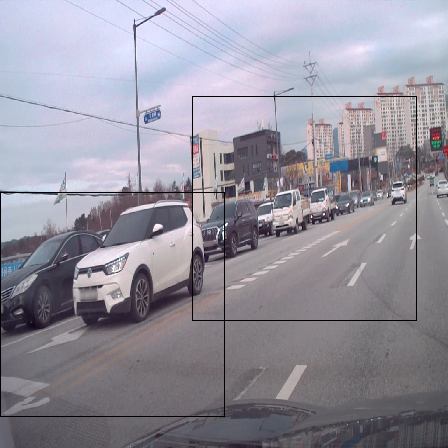

In [5]:
img_street = image.load_img("data/image/13646873.jpg", target_size=(448, 448))
draw = ImageDraw.Draw(img_street)
draw.rectangle((192, 96, 416, 320), outline=(0, 0, 0))
draw.rectangle((0, 192, 224, 416), outline=(0, 0, 0))
img_street

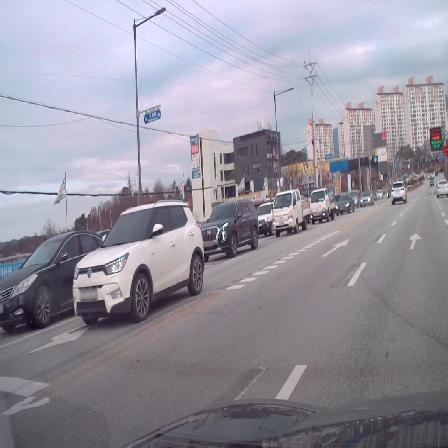

In [6]:
street2 = preprocess_image("data/image/13646873.jpg", target_size=(448, 448))
showarray(deprocess_image(street2, 448, 448))

In [12]:
crops = []
for x in range(7):
    for y in range(7):
        crops.append(street2[0, x * 32: x * 32 + 224, y * 32: y * 32 + 224, :])
crops = np.asarray(crops)

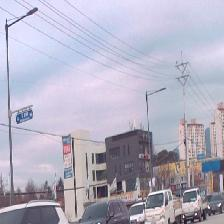

In [14]:
showarray(deprocess_image(crops[4], 224, 224))

In [15]:
preds = base_model.predict(vgg16.preprocess_input(crops))
crop_scores = defaultdict(list)
for idx, pred in enumerate(vgg16.decode_predictions(preds, top=1)):
    _, label, weight = pred[0]
    crop_scores[label].append((idx, weight))
crop_scores.keys()

2021-11-10 13:07:50.152415: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29503488 exceeds 10% of free system memory.
2021-11-10 13:07:50.188405: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29503488 exceeds 10% of free system memory.
2021-11-10 13:07:50.220089: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2021-11-10 13:07:50.755677: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-10 13:07:50.755917: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if 

dict_keys(['traffic_light', 'airship', 'moving_van', 'half_track', 'police_van', 'trolleybus', 'streetcar', 'minivan', 'limousine', 'trailer_truck', 'tow_truck', 'recreational_vehicle', 'garbage_truck', 'snowplow'])

4


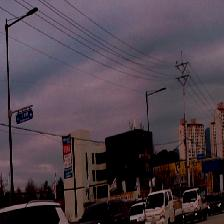

In [16]:
def best_image_for_label(l, label):
    idx = max(l[label], key=lambda t:t[1])[0]
    print(idx)
    return deprocess_image(crops[idx,:,:,:], 224, 224)

showarray(best_image_for_label(crop_scores, 'traffic_light'))

26


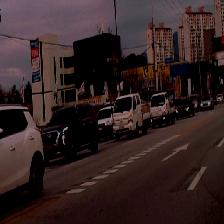

In [17]:
showarray(best_image_for_label(crop_scores, 'police_van'))

In [18]:
def create_top_model(base_model):
    inputs = Input(shape=(7, 7, 512), name='input')
    flatten = Flatten(name='flatten')(inputs)
    fc1 = Dense(4096, activation='relu', name='fc1')(flatten)
    fc2 = Dense(4096, activation='relu', name='fc2')(fc1)
    predictions = Dense(1000, activation='softmax', name='predictions')(fc2)
    model = Model(inputs, predictions, name='top_model')
    for layer in model.layers:
        if layer.name != 'input':
            print(layer.name)
            layer.set_weights(base_model.get_layer(layer.name).get_weights())
    return model

top_model = create_top_model(base_model)
top_model.summary()

flatten
fc1
fc2
predictions
Model: "top_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 7, 7, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 predictions (Dense)         (None, 1000)              4097000   
                                                                 
Total params: 123,642,856
Trainable params: 123,642,856
Non-trainable params: 0
_________________________________________________________________


In [19]:
bottom_model = vgg16.VGG16(weights='imagenet', include_top=False)
bottom_model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [20]:
p0 = base_model.predict(crops[:1])
vgg16.decode_predictions(p0, top=1)

[[('n06874185', 'traffic_light', 0.40481713)]]

In [21]:
b0 = bottom_model.predict(crops[:1])
t0 = top_model.predict(b0[:, :, :, :])
vgg16.decode_predictions(t0, top=1)

[[('n06874185', 'traffic_light', 0.40481713)]]